<a href="https://colab.research.google.com/github/MAI3003-Data-Witches/Data-Witches_Project1/blob/main/MAI3003_Data_Witches_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MAI3003 - Data Witches**

**Name**  | **Student ID**
-------------------|------------------
Claessen, VVHJAE | i6339543
Ovsiannikova, AM | i6365923
Pubben, J | i6276134
Roca Cugat, M | i6351071
Záboj, J| i6337952

# **Logbook**

▶▶**Please make a copy of the notebook to work in. Let's keep this one as our final notebook (and updated with code ofc).**◀◀

**Changes**
Also see Git Commit History.

| **Version** | **Changes**    | **Date** |
|-------------|----------------|----------|
| v0.0        | Dataset loaded | 02-11-25 |
| v0.1        | Data cleaning  | 05-11-25 |

## **Methods**

Let's ensure we all use the same names for all components.  

| **Variable**         | **Name**       |
|----------------------|----------------|
| Dataframe (raw)      | hcv            |
| Encoded dataframe    | hcv_encoded    |
| Imputed dataframe    | hcv_imputed    |
| Dataframe unskewed   | hcv_unskewed   |
| Dataframe normalized | hcv_normalized |

| **Function**              | **Description**                        | **Arguments**                                    |
|---------------------------|----------------------------------------|--------------------------------------------------|
| corr_plot()               | Correlation plot                       | df                                               |
| distplots()               | Distribution plots                     | df                                               |
| drop_high_missing_cols()  | Drop columns with missings             | df, threshold                                    |
| _reconstruct_dataframe()  | Reconstruction function for imputation | encoded_df, original_df, num_cols, cat_cols, enc |
| knn_impute()              | Distribution plots                     | df, min_thresh, max_thresh, n_neighbors          |
| impute_simple_central()   | Distribution plots                     | df, max_thresh                                   |
| normality_check_and_fix() | Distribution plots                     | df                                               |
| skewness_check()          | Distribution plots                     | df                                               |




# Preamble

## Libraries and other imports 

In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style

from scipy import stats
from scipy.stats import levene

import numpy as np
from numpy.ma.core import indices

import sklearn
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import warnings

In [124]:
missing  = 0
misVariables = []
sklearn.set_config(transform_output="pandas")

# Change False to True during development, they are used to ignore warnings when in "prod".
if True: warnings.filterwarnings('ignore')


### Load dataset

In [125]:
hcv = pd.read_csv('https://archive.ics.uci.edu/static/public/571/data.csv')

hcv

,ID,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,CGT,PROT,Category
0,1,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0=Blood Donor
1,2,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0=Blood Donor
2,3,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0=Blood Donor
3,4,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0=Blood Donor
4,5,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0=Blood Donor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,611,62,f,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5,3=Cirrhosis
611,612,64,f,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3,3=Cirrhosis
612,613,64,f,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0,3=Cirrhosis
613,614,46,f,33.0,NaN,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0,3=Cirrhosis


## Function declarations

### Graphs

#### Correlation plot

In [126]:
def corr_plot(input_df):
    sns.set_theme(style="white")
    corr = input_df.select_dtypes('number').corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(20, 5))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.5, vmin=-0.5, center=0,annot = False,
                 linewidths=.5, cbar_kws={"shrink": .8})

#### Distribution plots

In [127]:
def distplots(df):
    numeric_df = df.select_dtypes(include=['number'])
    num_features = len(numeric_df.columns)
    cols = int(np.ceil(np.sqrt(num_features)))
    rows = int(np.ceil(num_features / cols))

    # A figure with subplots looks much nicer
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()

    for i, column in enumerate(numeric_df.columns):
        # Technically not needed but might as well
        numeric_df_nona = numeric_df[column].dropna()

        axes[i].hist(numeric_df_nona, bins=30, alpha=0.7, edgecolor='black')

        if len(numeric_df_nona) > 1:
            density = stats.gaussian_kde(numeric_df_nona)
            xs = np.linspace(numeric_df_nona.min(), numeric_df_nona.max(), 200)
            axes[i].plot(xs, density(xs) * len(numeric_df_nona) * (numeric_df_nona.max() - numeric_df_nona.min()) / 30,
                         'r-', linewidth=2)

        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Number of Patients')
        axes[i].set_title(f'Distribution of {column}')
        axes[i].grid(axis='y', alpha=0.3)

    # Remove any empty subplots if they exist
    for j in range(num_features, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

### Imputation

#### Drop high missing columns

In [128]:
def drop_high_missing_cols(df, threshold):
    """
    1. Drops columns with a high percentage of missing values.
    """
    print(f"--- Running Step 1: Dropping columns > {threshold:.0%} missing ---")
    # Calculate missing percentage on the dataframe
    missing_pct = df.isnull().sum() / len(df)

    # Identify columns to drop based on the threshold
    cols_to_drop = missing_pct[missing_pct >= threshold].index.tolist()

    if cols_to_drop:
        print(f"   -> Dropping columns: {', '.join(cols_to_drop)}")
        # Drop columns from the dataframe
        df_dropped = df.drop(columns=cols_to_drop)
    else:
        print("   -> No columns exceeded the missing value threshold.")
        df_dropped = df.copy()

    return df_dropped

#### Dataframe reconstruction


In [129]:
def _reconstruct_dataframe(encoded_df, original_df, num_cols, cat_cols, enc):
    """
    Internal helper function to revert a one-hot encoded DataFrame
    back to its original shape.
    """
    # Isolate the imputed numerical data
    # Ensure we only select num_cols that are still in the encoded_df
    present_num_cols = [col for col in num_cols if col in encoded_df.columns]
    imputed_numerical = encoded_df[present_num_cols]

    # Isolate the encoded columns to be inverse-transformed
    encoded_cols_names = enc.get_feature_names_out(cat_cols)

    # Ensure all expected encoded columns are present, fill with 0 if not
    for col in encoded_cols_names:
        if col not in encoded_df.columns:
            encoded_df[col] = 0

    imputed_encoded = encoded_df[encoded_cols_names]

    # Perform the inverse transform
    imputed_categorical_array = enc.inverse_transform(imputed_encoded)

    # Convert the result back to a DataFrame
    imputed_categorical = pd.DataFrame(imputed_categorical_array,
                                       columns=cat_cols,
                                       index=encoded_df.index)

    # Combine numerical and reverted categorical data
    reconstructed_df = pd.concat([imputed_numerical, imputed_categorical], axis=1)

    # Enforce the original column order
    # Use .columns.intersection() to avoid errors if columns were dropped
    original_cols_present = original_df.columns.intersection(reconstructed_df.columns)
    final_df = reconstructed_df.reindex(columns=original_cols_present)

    return final_df

#### KNN imputation

In [130]:
def knn_impute(df, min_thresh, max_thresh, n_neighbors):
    """
    2. Uses KNN Imputation for columns with moderate missing values (5%-50%).

    What the function does:
    - One-hot encodes categorical data.
    - Trains KNN models (Regressor or Classifier) on the data
      to predict its own missing values.
    - Reconstructs the dataframe back to its original format.
    """
    print(f"\n--- Running Step 2: KNN Imputation ({min_thresh:.0%} - {max_thresh:.0%} missing) ---")
    # Create a copy to avoid modifying the original dataframe
    df_encoded = df.copy()

    # --- 2. KNN Imputation on Data ---

    # Calculate means *once* to be used for filling features (not targets)
    feature_fill_values = df_encoded.mean()

    for col in df_encoded.columns:
        missing_pct = df_encoded[col].isnull().mean()

        # Apply KNN to columns with moderate missingness
        if min_thresh <= missing_pct <= max_thresh:
            print(f"   -> KNN Imputing '{col}' (Missing: {missing_pct:.2%})")

            other_cols = [c for c in df_encoded.columns if c != col]

            # Split data for the imputer model
            train_rows = df_encoded[col].notnull()
            predict_rows = df_encoded[col].isnull()

            # If no rows to predict, skip
            if not predict_rows.any():
                print(f"      -> Skipping '{col}', no rows to predict.")
                continue

            # Fill NaNs in *features* with the mean for model stability
            X_train = df_encoded.loc[train_rows, other_cols].fillna(feature_fill_values)
            y_train = df_encoded.loc[train_rows, col]
            X_predict = df_encoded.loc[predict_rows, other_cols].fillna(feature_fill_values)

            # Select and train the appropriate KNN model
            is_binary = y_train.nunique() <= 2
            model = KNeighborsClassifier(n_neighbors=n_neighbors) if is_binary else KNeighborsRegressor(
                n_neighbors=n_neighbors)

            model.fit(X_train, y_train)
            predicted_values = model.predict(X_predict)

            # Assign the predicted values back to the encoded dataframe
            df_encoded.loc[predict_rows, col] = predicted_values
            print(f"      -> Successfully imputed {len(predicted_values)} values.")

    # --- 3. Reconstruct DataFrame ---

    # If no encoding was done, just return the dataframe
    if encoder is None:
        print("   -> Skipping reconstruction (no categorical columns).")
        return df_encoded

    print("   -> Reconstructing dataframe...")
    # Reconstruct the dataframe
    df_reconstructed = _reconstruct_dataframe(
        df_encoded,
        df_imputed,  # Pass the original copy for column order
        numerical_cols,
        categorical_cols,
        encoder
    )
    df_reconstructed.sort_index(inplace=True)

    return df_reconstructed

#### Normal imputation

In [131]:
def impute_simple_central(df, max_thresh):
    """
    3. Uses simple imputation (median/mode) for columns with < 5% missing values.

    This function learns the imputation value (median for numeric, mode for
    categorical) from the dataframe and applies it to fill its own NaNs.
    """
    print(f"\n--- Running Step 3: Simple Imputation (< {max_thresh:.0%} missing) ---")
    df_imputed = df.copy()

    for col in df_imputed.columns:
        # Calculate the percentage of missing values
        missing_pct = df_imputed[col].isnull().mean()

        # Check if the column fits the < 5% criteria
        if 0 < missing_pct < max_thresh:
            print(f"   -> Found '{col}' with {missing_pct:.2%} missing values. Imputing...")

            # Distinguish between numerical and categorical data
            if pd.api.types.is_numeric_dtype(df_imputed[col]):
                # For numerical columns, use the median
                fill_value = df_imputed[col].median()
                df_imputed[col].fillna(fill_value, inplace=True)
                print(f"      -> Filled with median: {fill_value}")
            else:
                # For categorical columns, use the mode
                fill_value = df_imputed[col].mode()[0]
                df_imputed[col].fillna(fill_value, inplace=True)
                print(f"      -> Filled with mode: '{fill_value}'")

    print("   -> Simple imputation complete.")
    return df_imputed

### Data cleaning

### Data encoding

In [132]:
def encode_categorical(df):
    categorical_cols = [col for col in df.columns
                        if df[col].dtype == 'object']
    numerical_cols = [col for col in df.columns
                      if df[col].dtype != 'object']

    # Initialize encoder
    encoder = TargetEncoder()

    # Handle case with no categorical columns
    if not categorical_cols:
        print("   -> No categorical columns found. Skipping encoding.")
        df_encoded = df.copy()
        encoder = None  # Flag that no encoder was used
    else:
        print(f"   -> Fitting TargetEncoder on {len(categorical_cols)} columns...")
        # Fit and transform the data
        encoded_cols_df = pd.DataFrame(encoder.fit_transform(df[categorical_cols]),
                                       columns=encoder.get_feature_names_out(categorical_cols),
                                       index=df.index)

        # Create the new, fully encoded dataframe
        df_encoded = df.drop(columns=categorical_cols).join(encoded_cols_df)
        print(f"   -> Data encoded. New shape: {df_encoded.shape}")

    return df_encoded

#### Normality check and correction

In [133]:
def normality_check_and_fix(df):
    df_normalized = df.copy()
    print("Shapiro-Wilk Normality Test")

    for column in df.columns:
        data_nona = df[column].dropna()
        stat, p_value = stats.shapiro(data_nona)

        if p_value > 0.05:
            print(Fore.GREEN + f"{column}: Normal (p={p_value:.4f})")
        else:
            print(Fore.RED + f"{column}: Not Normal (p={p_value:.4f})")
            df_normalized[column] = normalize(df[column])
    print(Style.RESET_ALL)
    return df_normalized

In [134]:
def normalize(df): # Only to be run on non-normal columns
    numeric_df = df.select_dtypes(include=['number'])
    data_nona = numeric_df.dropna()
    skewness = stats.skew(data_nona)
    df_normalized = df.copy()
    if skewness > 0.5:  # Right-skewed
        # Log transformation (with handling of zero-values)
        if (data_nona > 0).all():
            df_normalized = np.log(df)
            print(f"      -> Applied log transformation")
        else:
            df_normalized = np.log1p(df)
            print(f"      -> Applied log1p transformation")
    else:
        # Box-Cox transformation (requires positive values)
        if (data_nona > 0).all():
            transformed, _ = stats.boxcox(data_nona)
            df_normalized.loc[data_nona.index] = transformed
            print(f"      -> Applied Box-Cox transformation")
        else:
            # Square root transformation for zero-values
            if (data_nona >= 0).all():
                df_normalized = np.sqrt(df)
                print(f"      -> Applied square root transformation")
            else:
                print(f"      -> Skipped (contains negative values)")

    return df_normalized

#### Skewness check

In [135]:
def skewness_check(df):
    for column in df:
        skewness = stats.skew(df[column])
        if skewness > 1:
            print(Fore.RED + f"{column} is strongly right skewed (skew: {skewness:.3f})")
        elif skewness > 0.5:
            print(Fore.RED + f"{column} is moderately right skewed (skew: {skewness:.3f})")
        elif stats.skew(df[column]) < -1:
            print(Fore.MAGENTA + f"{column} is strongly left skewed (skew: {skewness:.3f})")
        elif stats.skew(df[column]) < -0.5:
            print(Fore.MAGENTA + f"{column} is moderately left skewed (skew: {skewness:.3f})")
        else:
            print(Fore.GREEN + f"{column} is symmetric (skew: {skewness:.3f})")
    print(Style.RESET_ALL)

In [136]:
hcv

,ID,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,CGT,PROT,Category
0,1,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0=Blood Donor
1,2,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0=Blood Donor
2,3,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0=Blood Donor
3,4,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0=Blood Donor
4,5,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0=Blood Donor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,611,62,f,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5,3=Cirrhosis
611,612,64,f,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3,3=Cirrhosis
612,613,64,f,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0,3=Cirrhosis
613,614,46,f,33.0,NaN,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0,3=Cirrhosis


# Exploratory Data Analysis

In [137]:
hcv

,ID,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,CGT,PROT,Category
0,1,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0=Blood Donor
1,2,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0=Blood Donor
2,3,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0=Blood Donor
3,4,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0=Blood Donor
4,5,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0=Blood Donor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,611,62,f,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5,3=Cirrhosis
611,612,64,f,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3,3=Cirrhosis
612,613,64,f,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0,3=Cirrhosis
613,614,46,f,33.0,NaN,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0,3=Cirrhosis


In [138]:
hcv.describe()

,ID,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,CGT,PROT
count,615.000000,615.000000,614.000000,597.000000,614.000000,615.000000,615.000000,615.000000,605.000000,615.000000,615.000000,614.000000
mean,308.000000,47.408130,41.620195,68.283920,28.450814,34.786341,11.396748,8.196634,5.368099,81.287805,39.533171,72.044137
std,177.679487,10.055105,5.780629,26.028315,25.469689,33.090690,19.673150,2.205657,1.132728,49.756166,54.661071,5.402636
min,1.000000,19.000000,14.900000,11.300000,0.900000,10.600000,0.800000,1.420000,1.430000,8.000000,4.500000,44.800000
25%,154.500000,39.000000,38.800000,52.500000,16.400000,21.600000,5.300000,6.935000,4.610000,67.000000,15.700000,69.300000
50%,308.000000,47.000000,41.950000,66.200000,23.000000,25.900000,7.300000,8.260000,5.300000,77.000000,23.300000,72.200000
75%,461.500000,54.000000,45.200000,80.100000,33.075000,32.900000,11.200000,9.590000,6.060000,88.000000,40.200000,75.400000
max,615.000000,77.000000,82.200000,416.600000,325.300000,324.000000,254.000000,16.410000,9.670000,1079.100000,650.900000,90.000000


In [ ]:
distplots(hcv)

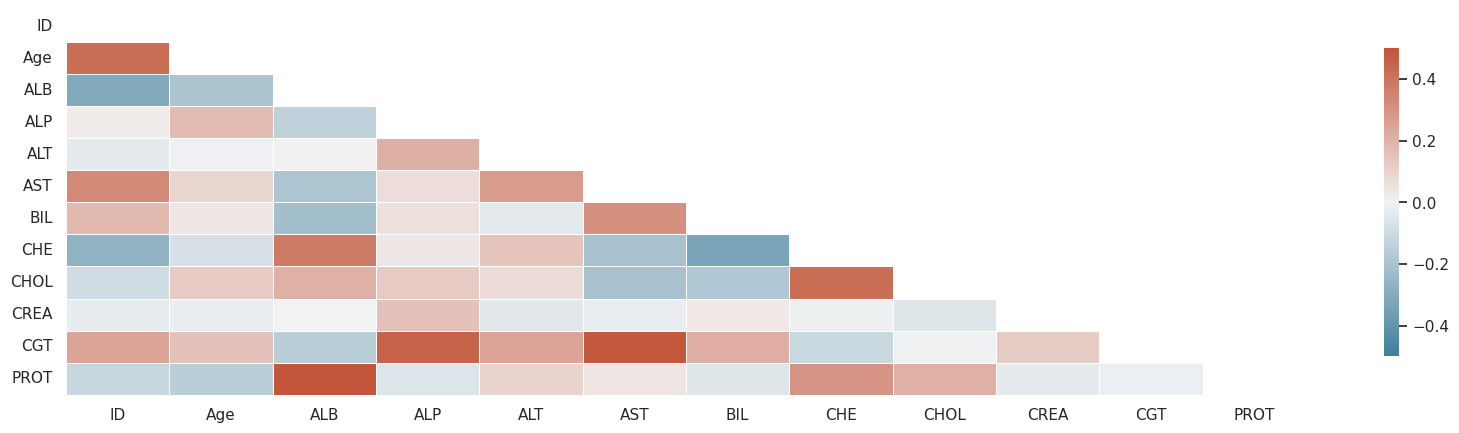

In [106]:
corr_plot(hcv.select_dtypes(include=['number']))

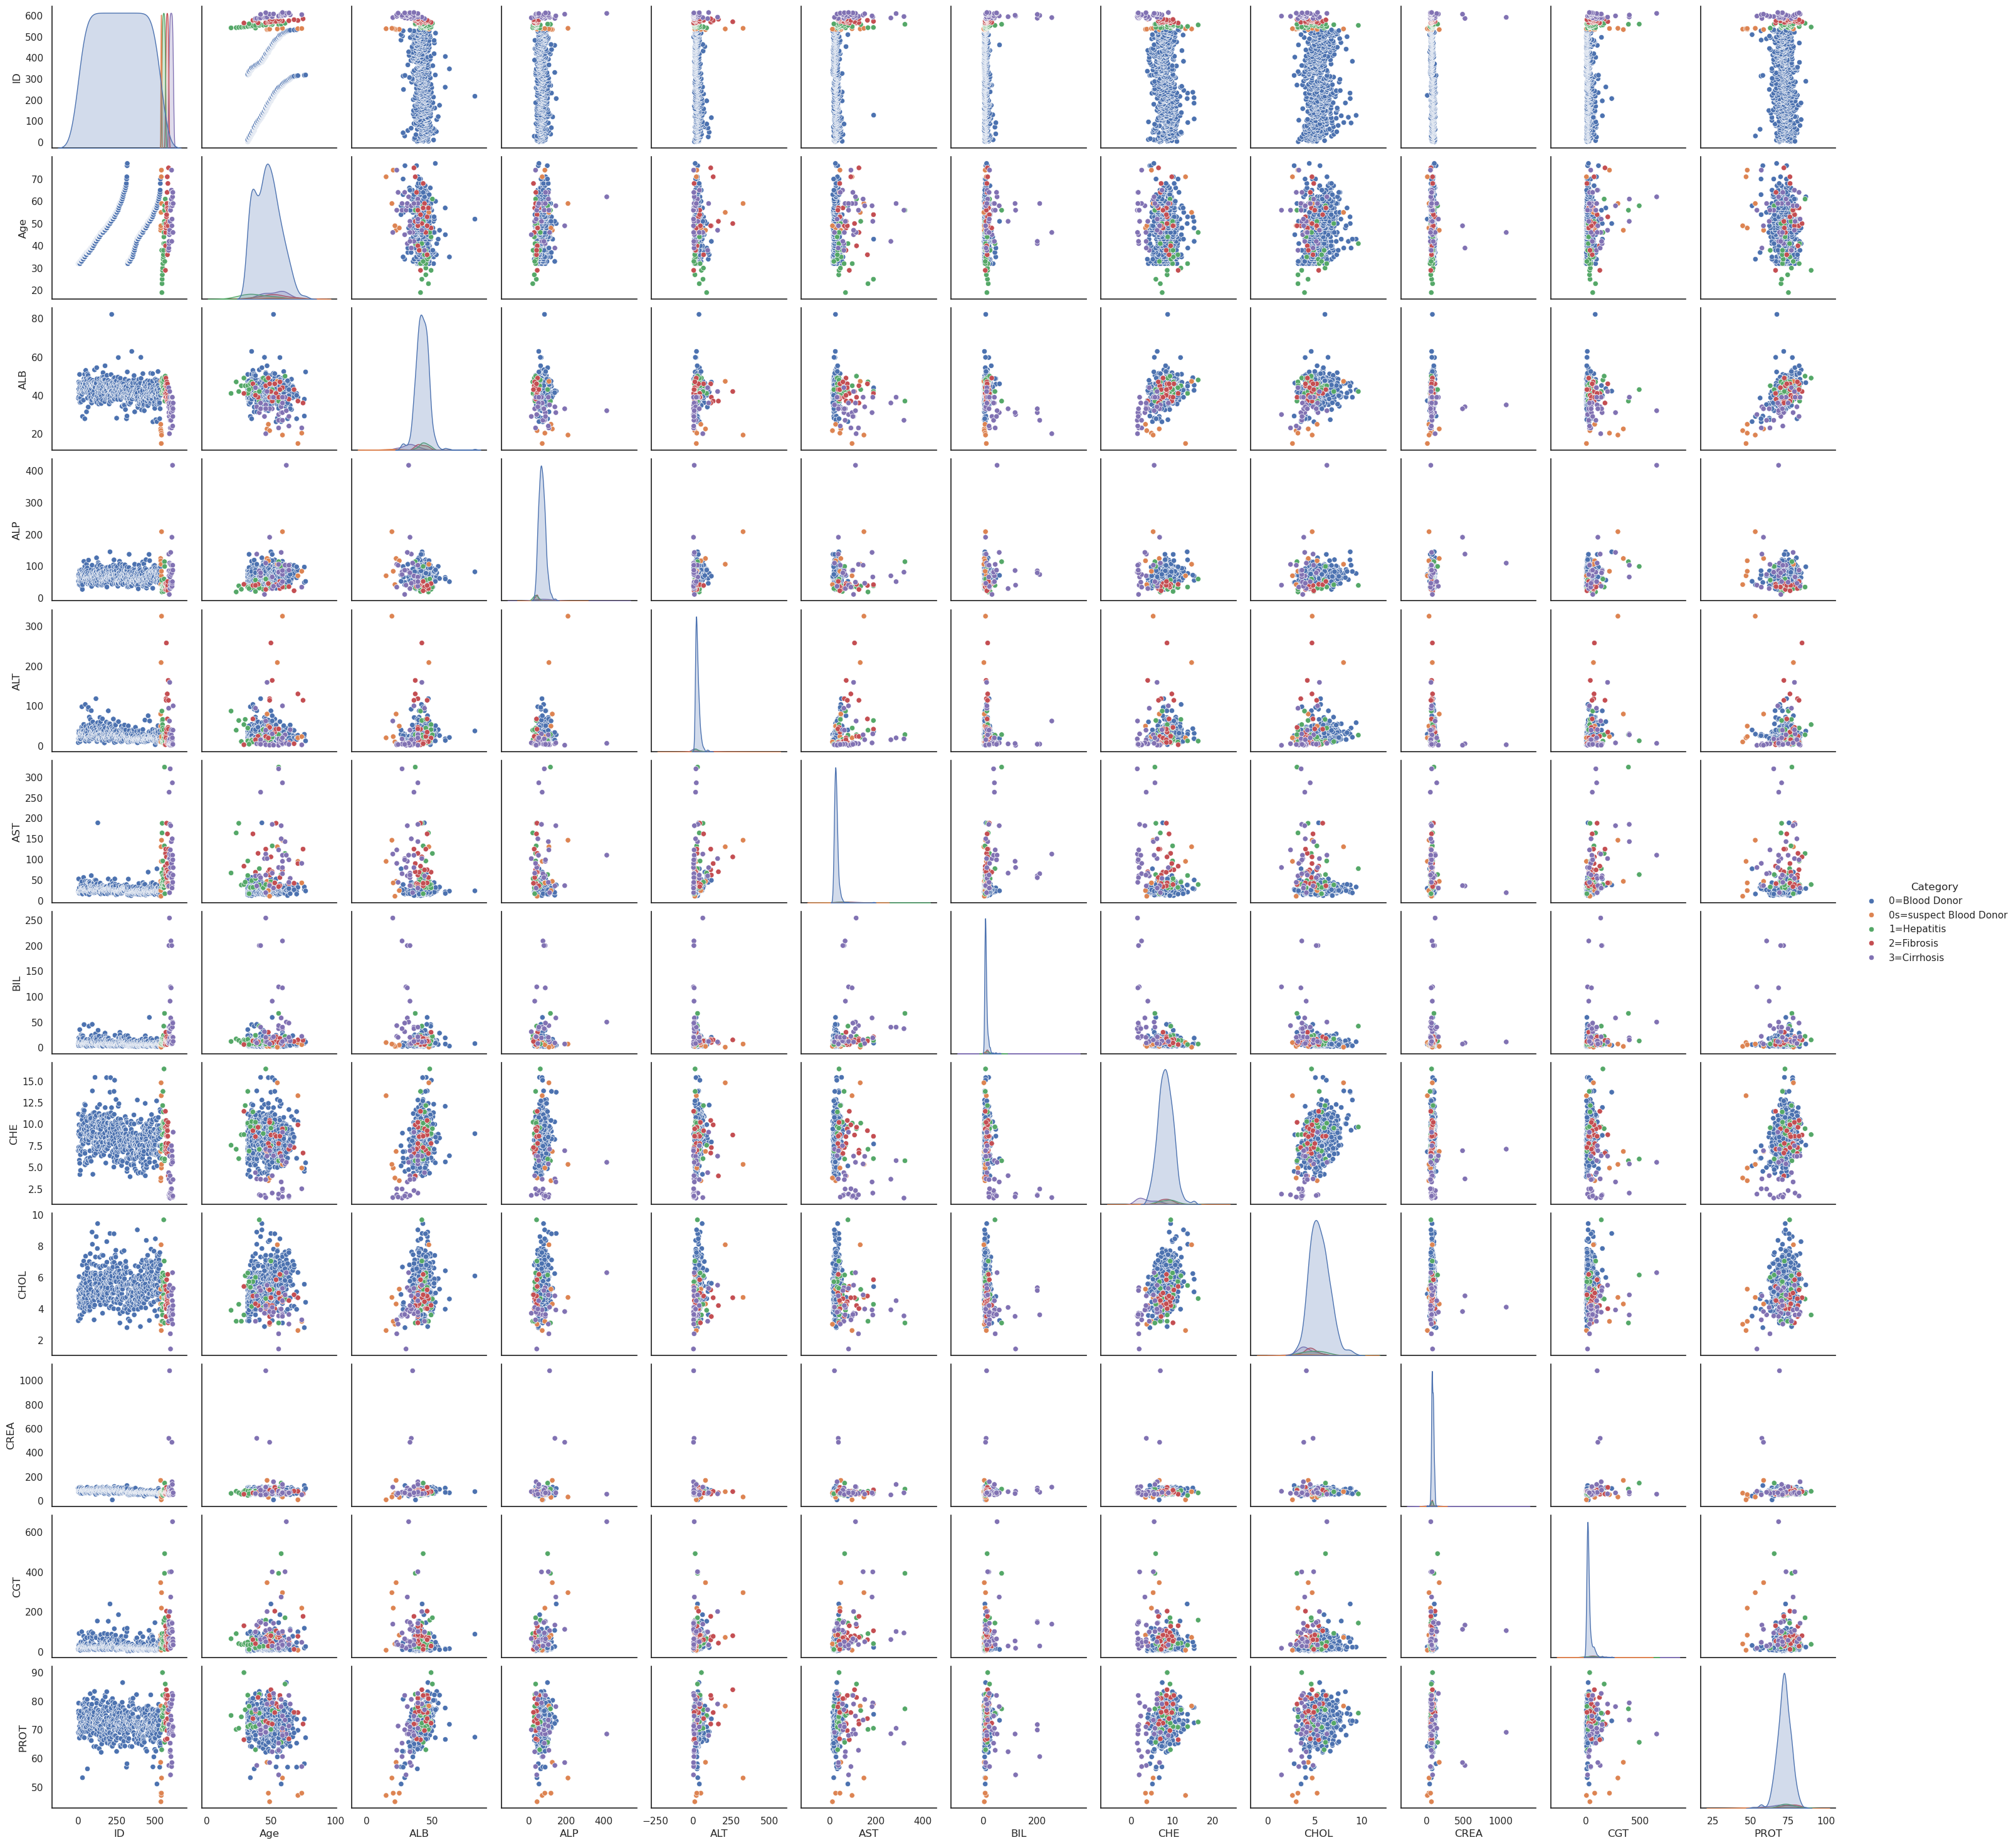

In [107]:
sns.pairplot(hcv, hue='Category')

# Data Preprocessing

In [113]:
hcv

,ID,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,CGT,PROT,Category
0,1,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0=Blood Donor
1,2,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0=Blood Donor
2,3,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0=Blood Donor
3,4,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0=Blood Donor
4,5,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0=Blood Donor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,611,62,f,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5,3=Cirrhosis
611,612,64,f,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3,3=Cirrhosis
612,613,64,f,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0,3=Cirrhosis
613,614,46,f,33.0,NaN,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0,3=Cirrhosis


In [108]:
print ("Old shape", hcv.shape)
hcv_encoded = encode_categorical(hcv, )

Old shape (615, 14)
   -> Fitting OneHotEncoder on 2 columns...
   -> Data encoded. New shape: (615, 19)


In [109]:
hcv_encoded

,ID,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,CGT,PROT,Sex_f,Sex_m,Category_0=Blood Donor,Category_0s=suspect Blood Donor,Category_1=Hepatitis,Category_2=Fibrosis,Category_3=Cirrhosis
0,1,32,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,2,32,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,3,32,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,4,32,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,5,32,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,611,62,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5,1.0,0.0,0.0,0.0,0.0,0.0,1.0
611,612,64,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3,1.0,0.0,0.0,0.0,0.0,0.0,1.0
612,613,64,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
613,614,46,33.0,NaN,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [110]:
numerical_cols = hcv.select_dtypes(include=np.number).columns
outlier_indices = {}

for col in numerical_cols:
    Q1 = hcv[col].quantile(0.25)
    Q3 = hcv[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    indices = hcv[(hcv[col] < lower_bound) | (hcv[col] > upper_bound)].index
    if len(indices) > 0:
            outlier_indices[col] = indices.tolist()
            #print(f'{len(indices)} outliers found in {col} column')
    else:
        pass
        #print(f"No outlier data found for column {col}")

outlier_values = []
outliers_count = 0
for col, rows in outlier_indices.items():
    outlier_values.append([col, len(rows), (len(rows)*10/ len(hcv[col]))])
    outliers_count = outliers_count + 1 if len(rows) > 0 else outliers_count

if outliers_count > 0:
    data_outliers = pd.DataFrame(outlier_values)
    data_outliers.columns = ['Variable', 'Outliers', 'Percentage Outliers']
    s = data_outliers.sort_values(by=['Percentage Outliers'], ascending=False).style.bar(subset=['Percentage Outliers'], color='#d65f5f')
    display(s)
else:
    print('No outlier values found in the dataset.')

,Variable,Outliers,Percentage Outliers
9,CGT,65,1.056911
4,AST,64,1.040650
5,BIL,47,0.764228
3,ALT,36,0.585366
1,ALB,27,0.439024
6,CHE,24,0.390244
10,PROT,20,0.325203
8,CREA,12,0.195122
7,CHOL,12,0.195122
2,ALP,10,0.162602


In [111]:
CheckNull = hcv.isnull().sum()
for var in range(0, len(CheckNull)):
    misVariables.append([hcv.columns[var], CheckNull[var], round(CheckNull[var]*10/len(hcv),3)])
    missing = missing + 1

if missing == 0:
    print('Dataset is complete with no blanks.')
else:
    data_misVariables = pd.DataFrame.from_records(misVariables)
    data_misVariables.columns = ['Variable', 'Missing', 'Percentage missing']
    s = data_misVariables.sort_values(by=['Percentage missing'], ascending=False).style.bar(subset=['Percentage missing'], color='#d65f5f')
    display(s)

,Variable,Missing,Percentage missing
4,ALP,18,0.293000
9,CHOL,10,0.163000
5,ALT,1,0.016000
3,ALB,1,0.016000
12,PROT,1,0.016000
0,ID,0,0.000000
2,Sex,0,0.000000
1,Age,0,0.000000
7,BIL,0,0.000000
6,AST,0,0.000000


In [112]:
hcv_dropped = drop_high_missing_cols(hcv, threshold=0.50)
hcv_knn_predicted= knn_impute(hcv_dropped, min_thresh=0.02, max_thresh=0.50, n_neighbors=5)
hcv_imputed = impute_simple_central(hcv_knn_predicted, max_thresh=0.05)

--- Running Step 1: Dropping columns > 50% missing ---
   -> No columns exceeded the missing value threshold.

--- Running Step 2: KNN Imputation (2% - 50% missing) ---


TypeError: Could not convert ['mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmfffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffmmmmmmfmmmmmmmmmmmmmmmmmmmmffffmmmmmmmmmmmmmffffffffmmmmmmmmmmmmmmmmmmmmffffffffff'
 '0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0=Blood Donor0s=suspect Blood Donor0s=suspect Blood Donor0s=suspect Blood Donor0s=suspect Blood Donor0s=suspect Blood Donor0s=suspect Blood Donor0s=suspect Blood Donor1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis1=Hepatitis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis2=Fibrosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis3=Cirrhosis'] to numeric

In [82]:
hcv_imputed

,ID,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,CGT,PROT,Category
0,1,32,m,38.5,52.50,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0=Blood Donor
1,2,32,m,38.5,70.30,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0=Blood Donor
2,3,32,m,46.9,74.70,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0=Blood Donor
3,4,32,m,43.2,52.00,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0=Blood Donor
4,5,32,m,39.2,74.10,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0=Blood Donor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,611,62,f,32.0,416.60,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5,3=Cirrhosis
611,612,64,f,24.0,102.80,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3,3=Cirrhosis
612,613,64,f,29.0,87.30,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0,3=Cirrhosis
613,614,46,f,33.0,48.42,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0,3=Cirrhosis


In [84]:
skewness_check(hcv_imputed)

ID is symmetric (skew: 0.000)
Age is symmetric (skew: 0.266)


TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [83]:
hcv_normalized = normality_check_and_fix(hcv_imputed)

Shapiro-Wilk Normality Test
ID: Not Normal (p=0.0000)


AttributeError: 'Series' object has no attribute 'select_dtypes'

# **Logistic Regression - All features**

## **Logistic Regression Model**

## **Forest Plot**

# **Logistic Regression - Selected features**

## **Feature selection**

## **Training/test set**


## **K-fold cross-validation**

## **Probabilistic model selection (AIC/BIC)**

# **Logistic Regression - Ranking**

## Main considerations
**1. What were your main considerations when selecting the best model?**


## Model explanation - Positive diagnosis
**2. Explain how your best model makes the decision for a positive diagnosis.**



## Model explanation - Over/underfitting, anchoring biases
**3. Explain how your proposed model addresses overfitting, underfitting, or anchoring biases *(choose one)* in training.**

# **Random Forest**

## **Random Forest model**

## **Feature importance measures**



## **SHAP values**